<a href="https://colab.research.google.com/github/oxanaRC/CE902/blob/main/Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

13.08.21
Upload three csv files:
1. dataset for training and testing 
2. dataset for validation
3. dataset for records identification ('location key', 'postal code' and 'district) - this to be joined with data after predictions were done so the quality of predictions could be analysed by location.



In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving train_and_test_data.csv to train_and_test_data.csv
Saving locations_categorical_features.csv to locations_categorical_features.csv
Saving validation_data.csv to validation_data.csv
User uploaded file "train_and_test_data.csv" with length 223688221 bytes
User uploaded file "locations_categorical_features.csv" with length 27878177 bytes
User uploaded file "validation_data.csv" with length 7581347 bytes


In [2]:
import pandas as pd
from pathlib import Path

In [48]:
df_location_categories = pd.read_csv("locations_categorical_features.csv") 
df_location_categories

,location_key,postcode,district
0,100000460_235813700_173697830,IP28 6QS,ST EDMUNDSBURY
1,100000900_306645770_193413260,PO2 9AE,PORTSMOUTH
2,100001709_306232250_192988720,PO2 8NT,PORTSMOUTH
3,100002450_241021470_178393000,IP33 3UF,ST EDMUNDSBURY
4,100002500_240933210_178314290,IP33 3UE,ST EDMUNDSBURY
...,...,...,...
563834,99996430_240804040_178195840,IP33 3UN,WEST SUFFOLK
563835,99996800_303056370_189735890,PO16 9PA,FAREHAM
563836,99998470_302856560_189531620,PO16 9UH,FAREHAM
563837,99998690_306575700_193341460,PO2 9BS,PORTSMOUTH


In [49]:
df_train_test_data = pd.read_csv("train_and_test_data.csv") 
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,this_price_per_bedroom,compare_ppd_re_hist_median_3mnths,compare_ppd_re_hist_median_4mnths,price_paid
0,1,L,T,23.0,110.178111,0.671216,96.0,0.5,0.9,60000.000000,56187.500000,7,26510768000,718540000,11622296000,53.489825,-2.358860,100000.0,66.666667,77.975528,100000.0
1,1,L,S,24.0,78.275669,0.320619,15.0,10.8,9.4,79166.666667,79000.000000,23,26539970000,542647000,11902983000,53.528583,-2.270335,79500.0,0.421053,0.632911,79500.0
2,1,L,F,12.0,85.979811,0.584296,20.0,11.5,9.8,73416.666667,64341.666667,4,16016690000,25505656000,21724217000,52.637255,1.298314,128000.0,74.347333,98.937961,128000.0
3,1,L,F,3.0,89.636307,0.452391,13.0,9.7,8.3,101666.666667,101666.666667,14,6296533000,26014878000,18039516000,51.868112,0.544362,170000.0,67.213115,67.213115,170000.0
4,1,F,S,6.0,55.701643,1.752959,14.0,11.9,11.0,136250.000000,168104.166667,18,4111570000,27468619000,16632627000,51.236727,-0.560636,655000.0,380.733945,289.639361,655000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144234,5,F,D,1.0,0.000000,0.000000,0.0,0.0,0.0,87250.000000,92500.000000,16,18126308000,28825475000,18214946000,50.896436,-2.576097,114000.0,30.659026,23.243243,570000.0
1144235,5,F,D,24.0,97.697793,1.639435,97.0,1.9,2.8,105000.000000,107500.000000,4,25424316000,711278000,10659618000,53.417210,-2.246727,178000.0,69.523810,65.581395,890000.0
1144236,5,F,S,6.0,193.121503,1.094252,26.0,8.7,8.3,89750.000000,92500.000000,9,8815989000,34831047000,24742056000,50.868112,0.567342,65600.0,-26.908078,-29.081081,328000.0
1144237,5,F,D,6.0,46.650826,2.156095,27.0,9.5,8.1,57750.000000,57750.000000,2,29718009000,3717254000,14712579000,53.731672,-2.624259,42800.0,-25.887446,-25.887446,214000.0


In [50]:
df_validation_data = pd.read_csv("validation_data.csv") 
df_validation_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,this_price_per_bedroom,compare_ppd_re_hist_median_3mnths,compare_ppd_re_hist_median_4mnths,price_paid
0,1,L,F,54.0,92.304597,0.543902,36.0,11.4,9.6,285000.000000,326250.000000,26,770794900,26771245000,16701868000,51.446749,-0.137157,314000.0,10.175439,-3.754789,314000.0
1,1,F,T,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.333333,119166.666667,26,2095469000,26684681000,17218624000,51.564821,0.123801,225000.0,98.529412,88.811189,225000.0
2,1,L,F,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.000000,80000.000000,26,10333301000,30370523000,19027695000,50.830953,-1.173732,120000.0,29.380054,50.000000,120000.0
3,1,L,F,60.0,104.272807,0.530036,60.0,9.2,8.7,219083.333333,240000.000000,26,502176000,26527685000,16536000000,51.478533,-0.121591,500000.0,128.223659,108.333333,500000.0
4,1,L,F,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.000000,42908.333333,26,32407942000,6604266000,17029935000,53.856740,-3.027827,52000.0,23.809524,21.188580,52000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38522,5,F,D,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.000000,55333.333333,26,22886393000,4770220000,7212565000,53.060015,-2.388207,78750.0,50.000000,42.319277,393750.0
38523,5,F,S,1.0,62.208157,4.362943,38.0,7.5,7.3,92333.333333,97000.000000,26,8821511000,25299709000,18394460000,52.085717,0.720703,186000.0,101.444043,91.752577,930000.0
38524,5,F,D,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.833333,106666.666667,26,6938065000,27433863000,19483321000,51.800099,0.725616,112000.0,6.140178,5.000000,560000.0
38525,5,F,T,9.0,103.448709,1.487324,16.0,10.7,10.2,163958.333333,158791.666667,26,7548684000,32765304000,21992537000,50.834805,-0.137428,108400.0,-33.885642,-31.734453,542000.0


In [51]:
#remove outliers
#df_train_test_data=df_train_test_data[(df_train_test_data['num_of_beds'] <=5) & (df_train_test_data['price_paid'] > 10000) & (df_train_test_data['price_paid'] <1000000) ]
#df_validation_data=df_validation_data[(df_validation_data['num_of_beds'] <=5) & (df_validation_data['price_paid'] > 10000) & (df_validation_data['price_paid'] <1000000) ]
#remove outliers
df_train_test_data=df_train_test_data[(df_train_test_data['closest_sch_distance'] !=0) ]
df_validation_data=df_validation_data[(df_validation_data['closest_sch_distance'] !=0) ]

In [52]:
#remove columns: 'this_price_per_bedroom',	'compare_ppd_re_hist_median_3mnths',	'compare_ppd_re_hist_median_4mnths'
df_train_test_data=df_train_test_data.drop(['this_price_per_bedroom', 'compare_ppd_re_hist_median_3mnths','compare_ppd_re_hist_median_4mnths'], axis = 1)
df_validation_data=df_validation_data.drop(['this_price_per_bedroom', 'compare_ppd_re_hist_median_3mnths','compare_ppd_re_hist_median_4mnths'], axis = 1)


In [53]:
estateTypes=df_train_test_data['estate_type'].unique()
estateTypes

array(['L', 'F'], dtype=object)

In [54]:
df_train_test_data['estate_type'] =df_train_test_data['estate_type'].map({'F':'2',
                             'L':'1'})
df_validation_data['estate_type'] =df_validation_data['estate_type'].map({'F':'2',
                             'L':'1'})


In [55]:
propertyTypes=df_train_test_data['property_type'].unique()
propertyTypes

array(['T', 'S', 'F', 'D'], dtype=object)

In [56]:
df_train_test_data['property_type'] =df_train_test_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})
df_validation_data['property_type'] =df_validation_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})

              

In [57]:
#shuffle the train_test dataset
df_train_test_data = df_train_test_data.sample(frac = 1)
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
54507,2,1,1,9.0,114.049352,0.482908,16.0,11.2,10.2,66250.000000,75000.000000,25,32118647000,6280924000,16782414000,53.846112,-2.978820,275000.0
962878,4,2,3,5.0,40.807297,1.341363,14.0,10.2,9.6,73416.666667,73000.000000,19,15597988000,10681524000,2433131000,52.602325,-1.605971,302500.0
55357,2,2,4,6.0,53.399369,0.757394,13.0,12.1,10.0,62000.000000,63000.000000,5,26626862000,6551183000,14913842000,53.787836,-1.402868,242500.0
353590,2,2,2,16.0,126.370455,0.897476,60.0,9.2,8.3,44166.666667,48575.000000,20,39192058000,17259745000,27708075000,54.956635,-1.426944,73000.0
927952,4,2,4,9.0,44.333362,0.863807,10.0,10.9,10.8,108333.333333,100000.000000,15,16104698000,23174439000,12639656000,51.401878,-2.485291,434000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463142,3,2,4,10.0,79.442159,0.550655,21.0,9.5,9.0,77666.666667,80000.000000,20,16208421000,25542751000,21841305000,52.651650,1.314245,265000.0
899548,3,1,2,11.0,72.495002,0.842542,44.0,9.0,8.5,42000.000000,46500.000000,16,27788250000,3248736000,12246851000,53.460625,-2.740886,121000.0
212953,2,2,4,1.0,169.854206,0.520832,31.0,10.3,8.3,116666.666667,116666.666667,2,16154718000,31988059000,20817231000,50.609297,-1.977301,300000.0
8845,1,2,2,8.0,56.848700,1.081614,43.0,8.8,7.7,150000.000000,135000.000000,16,8272182000,21169883000,14102001000,52.234014,0.131628,195000.0


In [58]:
dataset = df_train_test_data.values
dataset

array([[2, '1', '1', ..., 53.846112, -2.9788200000000002, 275000.0],
       [4, '2', '3', ..., 52.602325, -1.6059709999999998, 302500.0],
       [2, '2', '4', ..., 53.787836, -1.402868, 242500.0],
       ...,
       [2, '2', '4', ..., 50.609297, -1.9773009999999998, 300000.0],
       [1, '2', '2', ..., 52.234014, 0.131628, 195000.0],
       [2, '2', '2', ..., 51.882875, -1.7571869999999998, 245000.0]],
      dtype=object)

In [59]:
X1 = dataset[:,0:17]
Y1 = dataset[:,17]
#all features

In [60]:
validation_dataset=df_validation_data.values
validation_dataset

array([[1, '1', '1', ..., 51.446749, -0.137157, 314000.0],
       [1, '2', '2', ..., 51.564821, 0.123801, 225000.0],
       [1, '1', '1', ..., 50.830953, -1.173732, 120000.0],
       ...,
       [5, '2', '4', ..., 51.800098999999996, 0.725616, 560000.0],
       [5, '2', '2', ..., 50.834804999999996, -0.137428, 542000.0],
       [5, '2', '4', ..., 50.778189000000005, 0.102345, 412000.0]],
      dtype=object)

In [61]:
X_Validation=validation_dataset[:,0:17]
Y_Validation =validation_dataset[:,17]

In [62]:
from sklearn import preprocessing

In [63]:
min_max_scaler = preprocessing.MinMaxScaler()

In [64]:
X1_scale = min_max_scaler.fit_transform(X1)
X1_scale

array([[0.25      , 0.        , 0.        , ..., 0.44586818, 0.66549046,
        0.36521253],
       [0.75      , 1.        , 0.66666667, ..., 0.06344659, 0.4510971 ,
        0.5492422 ],
       [0.25      , 1.        , 1.        , ..., 0.39606902, 0.65544534,
        0.57646805],
       ...,
       [0.25      , 1.        , 1.        , ..., 0.55339977, 0.10755599,
        0.49946561],
       [0.        , 1.        , 0.33333333, ..., 0.37443271, 0.3876108 ,
        0.78216641],
       [0.25      , 1.        , 0.33333333, ..., 0.17785417, 0.32708447,
        0.52897177]])

In [65]:

print(min(Y1))
print(max(Y1))

14500.0
999999.0


In [66]:
X_Validation_scale = min_max_scaler.transform(X_Validation)
X_Validation_scale

array([[0.        , 0.        , 0.        , ..., 0.44372156, 0.2519088 ,
        0.74613592],
       [0.        , 1.        , 0.33333333, ..., 0.45749358, 0.27226104,
        0.7811172 ],
       [0.        , 0.        , 0.        , ..., 0.50570699, 0.14576315,
        0.6071836 ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.51784984, 0.31281625,
        0.86179018],
       [1.        , 1.        , 0.33333333, ..., 0.58472275, 0.14642713,
        0.7460996 ],
       [1.        , 1.        , 1.        , ..., 0.62384878, 0.13666815,
        0.77824104]])

In [67]:
print(min(Y_Validation))
print(max(Y_Validation))

18000.0
999000.0


In [68]:
from sklearn.model_selection import train_test_split

In [69]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scale, Y1, test_size=0.1)

In [70]:
print(X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape)

(947896, 17) (105322, 17) (947896,) (105322,)


In [71]:
from sklearn.ensemble import RandomForestRegressor

In [72]:
regr1 = RandomForestRegressor(max_depth=12, random_state=0)
regr1.fit(X1_train, Y1_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [73]:
prediction1=regr1.predict(X1_test)
#print(prediction1)

In [74]:
prediction_df1 = pd.DataFrame(min_max_scaler.inverse_transform(X1_test)) 
prediction_df1.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming', 'lat','long']
prediction_df1['Y1'] = Y1_test
prediction_df1['predictions1'] = prediction1
prediction_df1['error1']=prediction_df1['Y1']-prediction_df1['predictions1']
prediction_df1['sq_error1']=pow((prediction_df1['Y1']-prediction_df1['predictions1']),2)
prediction_df1['root_sq_error1']=pow(pow((prediction_df1['Y1']-prediction_df1['predictions1']),2),0.5)
prediction_df1['location_key']=(round((prediction_df1['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_df1['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_df1['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key
0,3.0,2.0,4.0,1.0,0.626997,5.921625,8.0,10.4,9.3,135000.000000,128750.000000,23.0,6.670817e+09,3.106892e+10,2.015642e+10,50.929975,-0.390753,538000,483337.600678,54662.4,2.98798e+09,54662.4,66708169_310689240_201564160
1,3.0,2.0,3.0,18.0,67.642349,0.382349,8.0,14.7,14.8,153916.666667,127083.333333,19.0,2.830089e+09,2.476161e+10,1.419294e+10,51.501397,-0.576129,700000,448938.999355,251061,6.30316e+10,251061,28300890_247616090_141929440
2,3.0,2.0,4.0,10.0,52.008647,2.591933,29.0,8.3,7.6,47750.000000,46958.333333,20.0,1.915725e+10,8.220218e+09,8.701885e+09,53.124128,-1.167954,235000,210643.983425,24356,5.93216e+08,24356,191572520_82202180_87018850
3,5.0,2.0,4.0,16.0,49.498108,0.247715,6.0,13.2,14.0,160950.000000,160950.000000,3.0,2.313298e+09,2.381194e+10,1.372531e+10,51.653009,-0.415869,822000,800330.432298,21669.6,4.6957e+08,21669.6,23132980_238119430_137253120
4,2.0,2.0,2.0,4.0,130.191074,0.776122,27.0,9.0,8.4,55208.333333,60000.000000,7.0,1.691739e+10,2.875429e+10,2.454927e+10,52.495034,1.720691,118000,119710.169956,-1710.17,2.92468e+06,1710.17,169173920_287542910_245492680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105317,2.0,2.0,4.0,33.0,61.280687,0.259241,29.0,10.8,9.6,153750.000000,153750.000000,1.0,1.536348e+09,2.727350e+10,1.702451e+10,51.375748,-0.186754,495000,478651.663955,16348.3,2.67268e+08,16348.3,15363480_272735000_170245120
105318,4.0,2.0,4.0,12.0,76.054939,1.273690,24.0,9.4,7.7,179625.000000,92500.000000,22.0,1.447828e+10,3.075668e+10,1.950329e+10,50.727691,-1.821899,395000,479731.067851,-84731.1,7.17935e+09,84731.1,144782820_307566830_195032940
105319,3.0,2.0,2.0,33.0,94.169916,0.343983,54.0,11.5,9.3,56000.000000,58500.000000,7.0,1.617552e+10,1.168176e+10,6.828750e+08,52.442914,-1.984479,139950,154492.395486,-14542.4,2.11481e+08,14542.4,161755250_116817550_6828750
105320,3.0,2.0,3.0,5.0,22.927221,0.819223,11.0,9.4,9.0,125000.000000,113666.666667,13.0,6.160137e+09,3.153326e+10,2.086556e+10,50.959890,-0.130978,380000,332171.128151,47828.9,2.2876e+09,47828.9,61601369_315332570_208655570


In [75]:
data_for_prediction_analysis = pd.merge(prediction_df1, df_location_categories, how="left", on="location_key")
data_for_prediction_analysis['postcode_area']=data_for_prediction_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,3.0,2.0,4.0,1.0,0.626997,5.921625,8.0,10.4,9.3,135000.000000,128750.000000,23.0,6.670817e+09,3.106892e+10,2.015642e+10,50.929975,-0.390753,538000,483337.600678,54662.4,2.98798e+09,54662.4,66708169_310689240_201564160,RH20 3DD,HORSHAM,RH20
1,3.0,2.0,3.0,18.0,67.642349,0.382349,8.0,14.7,14.8,153916.666667,127083.333333,19.0,2.830089e+09,2.476161e+10,1.419294e+10,51.501397,-0.576129,700000,448938.999355,251061,6.30316e+10,251061,28300890_247616090_141929440,SL3 7PF,SLOUGH,SL3
2,3.0,2.0,4.0,10.0,52.008647,2.591933,29.0,8.3,7.6,47750.000000,46958.333333,20.0,1.915725e+10,8.220218e+09,8.701885e+09,53.124128,-1.167954,235000,210643.983425,24356,5.93216e+08,24356,191572520_82202180_87018850,NG18 4QU,MANSFIELD,NG18
3,5.0,2.0,4.0,16.0,49.498108,0.247715,6.0,13.2,14.0,160950.000000,160950.000000,3.0,2.313298e+09,2.381194e+10,1.372531e+10,51.653009,-0.415869,822000,800330.432298,21669.6,4.6957e+08,21669.6,23132980_238119430_137253120,WD18 7UL,WATFORD,WD18
4,2.0,2.0,2.0,4.0,130.191074,0.776122,27.0,9.0,8.4,55208.333333,60000.000000,7.0,1.691739e+10,2.875429e+10,2.454927e+10,52.495034,1.720691,118000,119710.169956,-1710.17,2.92468e+06,1710.17,169173920_287542910_245492680,NR32 3BA,WAVENEY,NR32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105317,2.0,2.0,4.0,33.0,61.280687,0.259241,29.0,10.8,9.6,153750.000000,153750.000000,1.0,1.536348e+09,2.727350e+10,1.702451e+10,51.375748,-0.186754,495000,478651.663955,16348.3,2.67268e+08,16348.3,15363480_272735000_170245120,SM1 3LF,SUTTON,SM1
105318,4.0,2.0,4.0,12.0,76.054939,1.273690,24.0,9.4,7.7,179625.000000,92500.000000,22.0,1.447828e+10,3.075668e+10,1.950329e+10,50.727691,-1.821899,395000,479731.067851,-84731.1,7.17935e+09,84731.1,144782820_307566830_195032940,BH5 2AS,"BOURNEMOUTH, CHRISTCHURCH AND POOLE",BH5
105319,3.0,2.0,2.0,33.0,94.169916,0.343983,54.0,11.5,9.3,56000.000000,58500.000000,7.0,1.617552e+10,1.168176e+10,6.828750e+08,52.442914,-1.984479,139950,154492.395486,-14542.4,2.11481e+08,14542.4,161755250_116817550_6828750,B32 3AL,BIRMINGHAM,B32
105320,3.0,2.0,3.0,5.0,22.927221,0.819223,11.0,9.4,9.0,125000.000000,113666.666667,13.0,6.160137e+09,3.153326e+10,2.086556e+10,50.959890,-0.130978,380000,332171.128151,47828.9,2.2876e+09,47828.9,61601369_315332570_208655570,RH15 8JL,MID SUSSEX,RH15


In [76]:
#check NA in data_for_prediction_analysis
data_for_prediction_analysis_na=data_for_prediction_analysis[(data_for_prediction_analysis['postcode'].isnull())]
data_for_prediction_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [ ]:
from google.colab import files
with open('test data predictions.csv', 'w') as f:
  #f.write('some content')
  data_for_prediction_analysis.to_csv('test data predictions.csv', index=False)
files.download('test data predictions.csv')  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [77]:
root_mse1=pow(prediction_df1['sq_error1'].sum()/prediction_df1['sq_error1'].count(),0.5)
root_mse1

70028.1585899653

In [78]:
#considering good prediction where error 10% or less
prediction_df1['error_perc']=100*prediction_df1['root_sq_error1']/prediction_df1['Y1']
good_prediction_10pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1=100*good_prediction_10pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1 =prediction_df1[(prediction_df1['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1=100*good_prediction_15pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1) + ' %')
#prediction_20pc_df1
within_20pc_error1=100*prediction_20pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1) + ' %')
#prediction_50pc_df1
within_50pc_error1=100*prediction_over50pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1) + ' %')

Predictions where error is 10% or less :37.14133799206244 %
Predictions where error is 15% or less :52.2293537912307 %
Predictions where error is 20% or less :64.4547198116253 %
Predictions where error is 50% or more :6.483925485653519 %


In [79]:
prediction_validation=regr1.predict(X_Validation_scale)

In [80]:
prediction_validation_df = pd.DataFrame(min_max_scaler.inverse_transform(X_Validation_scale)) 
prediction_validation_df.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming', 'lat','long']
prediction_validation_df['Y_val_data'] = Y_Validation
prediction_validation_df['predictions_validation'] = prediction_validation
prediction_validation_df['error1']=prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']
prediction_validation_df['sq_error1']=pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2)
prediction_validation_df['root_sq_error1']=pow(pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2),0.5)
prediction_validation_df['location_key']=(round((prediction_validation_df['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_validation_df['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_validation_df['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_validation_df

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,285000.000000,326250.000000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,436014.954115,122015,1.48876e+10,122015,7707949_267712450_167018680
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.333333,119166.666667,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,289061.895085,64061.9,4.10393e+09,64061.9,20954690_266846810_172186240
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.000000,80000.000000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,117910.781206,-2089.22,4.36484e+06,2089.22,103333010_303705230_190276950
3,1.0,1.0,1.0,60.0,104.272807,0.530036,60.0,9.2,8.7,219083.333333,240000.000000,26.0,5.021760e+08,2.652768e+10,1.653600e+10,51.478533,-0.121591,500000,411504.253539,-88495.7,7.8315e+09,88495.7,5021760_265276850_165360000
4,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.000000,42908.333333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,68550.229650,16550.2,2.7391e+08,16550.2,324079420_66042660_170299350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35526,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.000000,55333.333333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,426825.297766,33075.3,1.09398e+09,33075.3,228863930_47702200_72125650
35527,5.0,2.0,3.0,1.0,62.208157,4.362943,38.0,7.5,7.3,92333.333333,97000.000000,26.0,8.821511e+09,2.529971e+10,1.839446e+10,52.085717,0.720703,930000,421027.504119,-508972,2.59053e+11,508972,88215110_252997090_183944600
35528,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.833333,106666.666667,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,589201.872365,29201.9,8.52749e+08,29201.9,69380650_274338630_194833210
35529,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,163958.333333,158791.666667,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,613625.232783,71625.2,5.13017e+09,71625.2,75486840_327653040_219925370


In [81]:
data_for_prediction_validation_analysis = pd.merge(prediction_validation_df, df_location_categories, how="left", on="location_key")
data_for_prediction_validation_analysis['postcode_area']=data_for_prediction_validation_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_validation_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,285000.000000,326250.000000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,436014.954115,122015,1.48876e+10,122015,7707949_267712450_167018680,SW12 0JP,LAMBETH,SW12
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.333333,119166.666667,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,289061.895085,64061.9,4.10393e+09,64061.9,20954690_266846810_172186240,RM8 1UG,REDBRIDGE,RM8
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.000000,80000.000000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,117910.781206,-2089.22,4.36484e+06,2089.22,103333010_303705230_190276950,PO13 0XF,GOSPORT,PO13
3,1.0,1.0,1.0,60.0,104.272807,0.530036,60.0,9.2,8.7,219083.333333,240000.000000,26.0,5.021760e+08,2.652768e+10,1.653600e+10,51.478533,-0.121591,500000,411504.253539,-88495.7,7.8315e+09,88495.7,5021760_265276850_165360000,SW8 1DL,LAMBETH,SW8
4,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.000000,42908.333333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,68550.229650,16550.2,2.7391e+08,16550.2,324079420_66042660_170299350,FY2 0HD,BLACKPOOL,FY2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35526,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.000000,55333.333333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,426825.297766,33075.3,1.09398e+09,33075.3,228863930_47702200_72125650,CW2 5FH,CHESHIRE EAST,CW2
35527,5.0,2.0,3.0,1.0,62.208157,4.362943,38.0,7.5,7.3,92333.333333,97000.000000,26.0,8.821511e+09,2.529971e+10,1.839446e+10,52.085717,0.720703,930000,421027.504119,-508972,2.59053e+11,508972,88215110_252997090_183944600,CO10 9DT,BABERGH,CO10
35528,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.833333,106666.666667,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,589201.872365,29201.9,8.52749e+08,29201.9,69380650_274338630_194833210,CO5 0PU,COLCHESTER,CO5
35529,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,163958.333333,158791.666667,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,613625.232783,71625.2,5.13017e+09,71625.2,75486840_327653040_219925370,BN1 4NN,BRIGHTON AND HOVE,BN1


In [82]:
#check NA in data_for_prediction_validation_analysis
data_for_prediction_validation_analysis_na=data_for_prediction_validation_analysis[(data_for_prediction_validation_analysis['postcode'].isnull())]
data_for_prediction_validation_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [83]:
root_mse_validation=pow(prediction_validation_df['sq_error1'].sum()/prediction_validation_df['sq_error1'].count(),0.5)
root_mse_validation

70478.66850650159

In [84]:
#considering good prediction where error 10% or less
prediction_validation_df['error_perc']=100*prediction_validation_df['root_sq_error1']/prediction_validation_df['Y_val_data']
good_prediction_validation_10pc_df1 =prediction_validation_df[(prediction_validation_df['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1_val=100*good_prediction_validation_10pc_df1.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1_val) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1_val=100*good_prediction_15pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1_val) + ' %')
#prediction_20pc_df1
within_20pc_error1_val=100*prediction_20pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1_val) + ' %')
#prediction_50pc_df1
within_50pc_error1_val=100*prediction_over50pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1_val) + ' %')

Predictions where error is 10% or less :36.89454279361684 %
Predictions where error is 15% or less :51.75480566266077 %
Predictions where error is 20% or less :63.440376009681685 %
Predictions where error is 50% or more :6.656159410092595 %


In [85]:
import matplotlib.pyplot as plt

In [86]:
import numpy as np

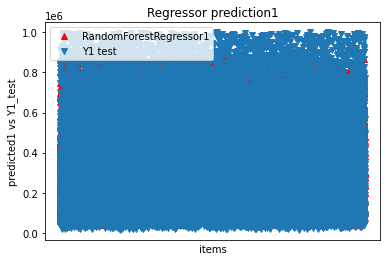

In [87]:
plt.figure()
plt.plot(prediction1, 'r^', label='RandomForestRegressor1')
plt.plot(Y1_test, 'v', label='Y1 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction1')

plt.show()

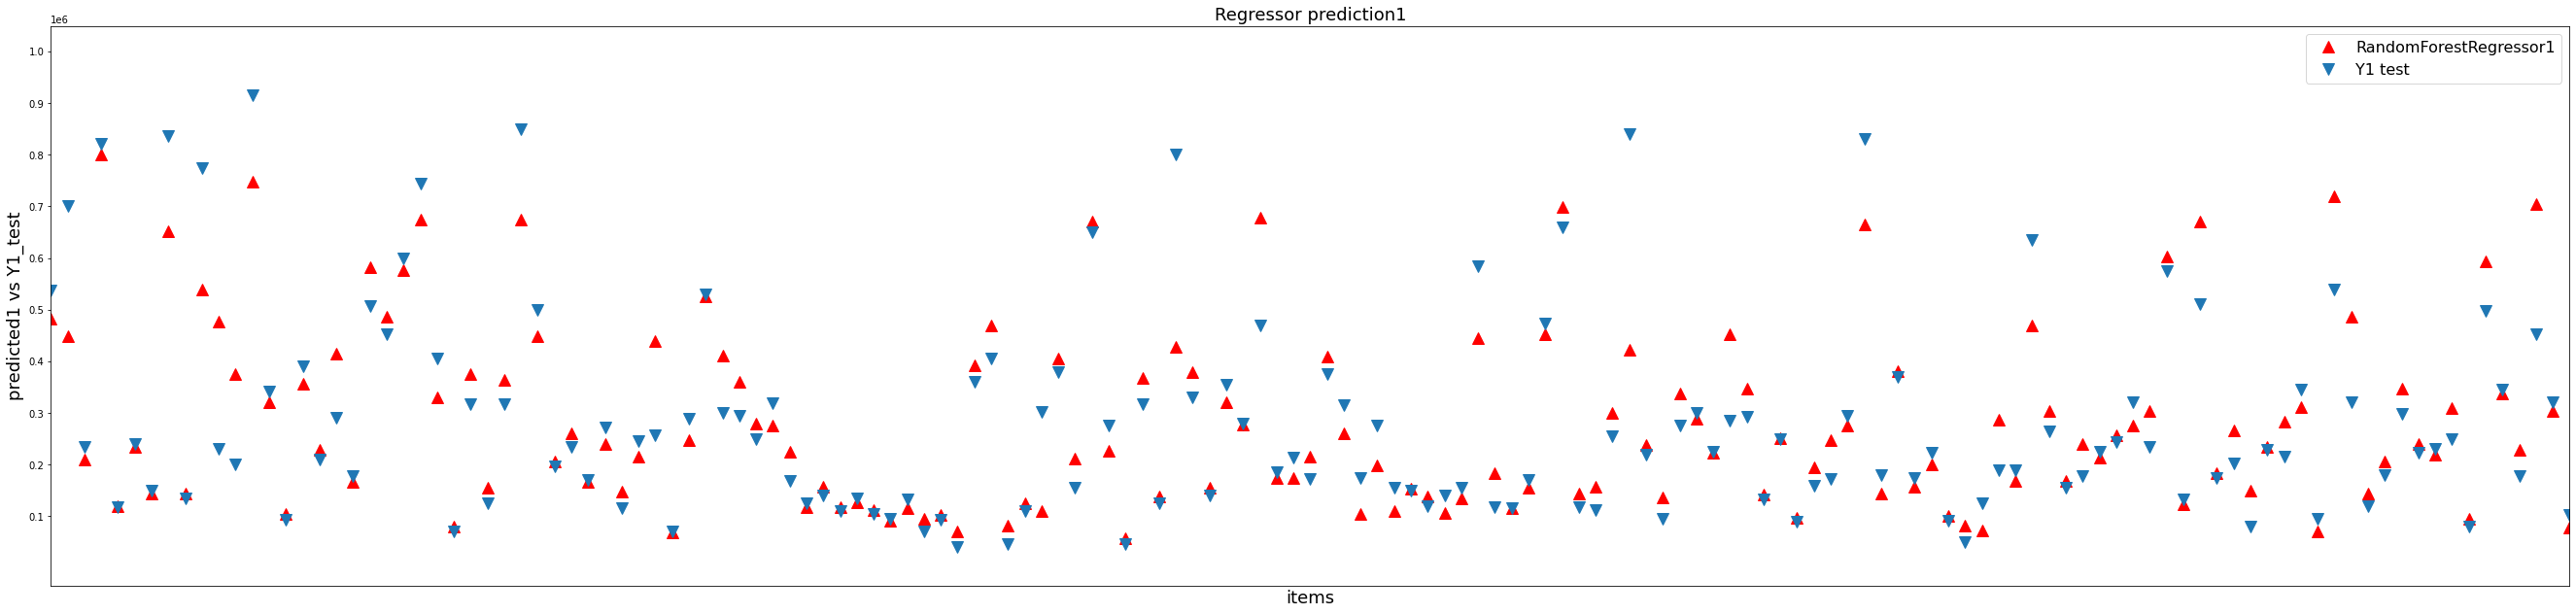

In [88]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000, 1000000,1100000,1200000, 1300000,1400000])
plt.yticks(np.arange(y.min(), y.max(), 100000))

axes.plot(prediction1, 'r^', label='RandomForestRegressor1',markersize=12)
axes.plot(Y1_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,150])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction1', fontsize=18)

plt.show()

In [89]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [90]:
mean_squared_error1=metrics.mean_squared_error(prediction1,Y1_test)
mean_squared_error1
root_mse1_2=pow(mean_squared_error1,0.5)
root_mse1_2

70028.15858996587

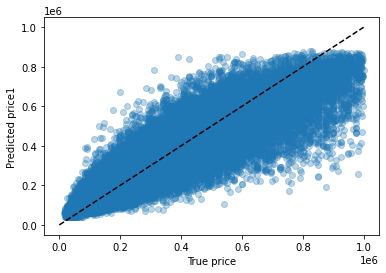

In [91]:
plt.scatter(Y1_test,prediction1,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price1')
plt.show()


In [92]:
mean_squared_error_validation=metrics.mean_squared_error(prediction_validation,Y_Validation)
mean_squared_error_validation
root_msev_2=pow(mean_squared_error_validation,0.5)
root_msev_2

70478.66850650166

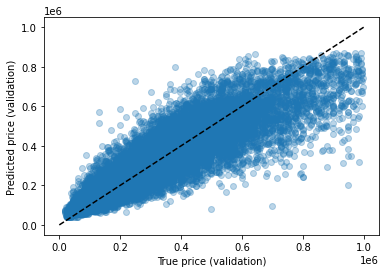

In [93]:
plt.scatter(Y_Validation,prediction_validation,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price (validation)')
plt.ylabel('Predicted price (validation)')
plt.show()